# Utiliza aprendizado de máquina para predizer evolução para UTI de pacientes de SRAG por influenza

In [2]:
import pandas as pd
import os
import datetime
import dateutil
import numpy as np
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score,
    classification_report, 
    ConfusionMatrixDisplay,
    confusion_matrix,
    make_scorer
)
import optuna
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [24]:
dados = pd.read_parquet('../influenza_ML_2025-10-30_16-28-12.parquet')

In [25]:
dados.head()

,DT_SIN_PRI,SG_UF_NOT,CO_MUN_NOT,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,ID_PAIS,SG_UF,CO_MUN_RES,CS_ZONA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,TABAG,VACINA,MAE_VAC,M_AMAMENTA,ANTIVIRAL,TP_ANTIVIR,HOSPITAL,SG_UF_INTE,CO_MU_INTE,UTI,RAIOX_RES,PCR_RESUL,POS_PCRFLU,TP_FLU_PCR,PCR_FLUASU,PCR_FLUBLI,POS_PCROUT,PCR_VSR,PCR_PARA1,PCR_PARA2,PCR_PARA3,PCR_PARA4,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TP_TES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,POV_CT,SURTO_SG,IDADE,DIAS_UL_VAC,DIAS_UL_VAC_MAE,DIAS_UL_VAC_DOSEUNI,DIAS_UL_VAC_1_DOSE,DIAS_UL_VAC_2_DOSE,DIAS_UL_INIC_ANTIVIRAL,DIAS_INTERNACAO,DIAS_INTERNA_RX_RESP,DIAS_SINT_INI_RX_RESP,DIAS_INTERNA_TOMO,DIAS_SINT_INI_TOMO
5472,2021-01-04,SP,355030.0,F,6,4,5.0,BRASIL,SP,355030.0,1.0,NaN,NaN,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,SP,355030.0,1.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,6.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN
7941,2021-01-08,GO,521020.0,F,5,1,1.0,BRASIL,GO,521020.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,None,NaN,2.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,27432.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
29382,2021-01-03,SP,350950.0,M,6,1,4.0,BRASIL,SP,350950.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,SP,350950.0,1.0,6.0,1.0,1.0,1.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,24398.0,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN,0.0,0.0
35455,2021-12-17,SP,355030.0,M,6,1,NaN,BRASIL,SP,355030.0,1.0,2.0,2.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,SP,355030.0,2.0,6.0,1.0,1.0,1.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,5.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,27505.0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,2.0,2.0
38164,2021-01-15,MA,211130.0,F,6,1,NaN,BRASIL,MA,211130.0,NaN,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,1.0,1.0,MA,211130.0,1.0,6.0,1.0,1.0,1.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1891.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,2.0,2.0


In [26]:
dados['OBES_IMC'].info()

<class 'pandas.core.series.Series'>
Index: 41891 entries, 5472 to 239453
Series name: OBES_IMC
Non-Null Count  Dtype  
--------------  -----  
207 non-null    float64
dtypes: float64(1)
memory usage: 654.5 KB


## Remoção de variáveis

Removemos data início de sintomas e o IMC, está última por estar preenchiada em apenas 207 registros. Febre por ser variável de definição de SRAG. A variável TABAG apresentava apenas valores 'nan'

In [27]:
dados.drop(['DT_SIN_PRI', 'OBES_IMC', 'FEBRE', 'TABAG'], axis=1, inplace=True)

## Remoção de registros sem resposta sobre internação em UTI

In [28]:
dados.drop(dados.loc[dados['UTI'] == 9].index, axis=0, inplace=True)

In [29]:
dados.drop(dados.loc[dados['UTI'].isnull()].index, axis=0, inplace=True)

In [30]:
colunas = dados.columns.to_list()

In [31]:
categoricas = ['SG_UF_NOT',
 'CO_MUN_NOT',
 'CS_SEXO',
 'CS_GESTANT',
 'CS_RACA',
 'CS_ESCOL_N',
 'ID_PAIS',
 'SG_UF',
 'CO_MUN_RES',
 'CS_ZONA',
 'NOSOCOMIAL',
 'AVE_SUINO',
 'TOSSE',
 'GARGANTA',
 'DISPNEIA',
 'DESC_RESP',
 'SATURACAO',
 'DIARREIA',
 'VOMITO',
 'PUERPERA',
 'CARDIOPATI',
 'HEMATOLOGI',
 'SIND_DOWN',
 'HEPATICA',
 'ASMA',
 'DIABETES',
 'NEUROLOGIC',
 'PNEUMOPATI',
 'IMUNODEPRE',
 'RENAL',
 'OBESIDADE',
 'VACINA',
 'MAE_VAC',
 'M_AMAMENTA',
 'ANTIVIRAL',
 'TP_ANTIVIR',
 'HOSPITAL',
 'SG_UF_INTE',
 'CO_MU_INTE',
 'UTI',
 'RAIOX_RES',
 'PCR_RESUL',
 'POS_PCRFLU',
 'TP_FLU_PCR',
 'PCR_FLUASU',
 'PCR_FLUBLI',
 'POS_PCROUT',
 'PCR_VSR',
 'PCR_PARA1',
 'PCR_PARA2',
 'PCR_PARA3',
 'PCR_PARA4',
 'PCR_ADENO',
 'PCR_METAP',
 'PCR_BOCA',
 'PCR_RINO',
 'PCR_OUTRO',
 'DOR_ABD',
 'FADIGA',
 'PERD_OLFT',
 'PERD_PALA',
 'TOMO_RES',
 'TP_TES_AN',
 'RES_AN',
 'POS_AN_FLU',
 'TP_FLU_AN',
 'POS_AN_OUT',
 'AN_SARS2',
 'AN_VSR',
 'AN_PARA1',
 'AN_PARA2',
 'AN_PARA3',
 'AN_ADENO',
 'AN_OUTRO',
 'POV_CT',
 'SURTO_SG',
]

In [32]:
for coluna in categoricas:
    dados[coluna] = dados[coluna].astype('category')

In [34]:
dados = dados[['CS_SEXO',
 'CS_GESTANT',
 'CS_RACA',
 'CS_ESCOL_N',
 'ID_PAIS',
 'CS_ZONA',
 'NOSOCOMIAL',
 'AVE_SUINO',
 'TOSSE',
 'GARGANTA',
 'DISPNEIA',
 'DESC_RESP',
 'SATURACAO',
 'DIARREIA',
 'VOMITO',
 'PUERPERA',
 'CARDIOPATI',
 'HEMATOLOGI',
 'SIND_DOWN',
 'HEPATICA',
 'ASMA',
 'DIABETES',
 'NEUROLOGIC',
 'PNEUMOPATI',
 'IMUNODEPRE',
 'RENAL',
 'OBESIDADE',
 'VACINA',
 'MAE_VAC',
 'M_AMAMENTA',
 'ANTIVIRAL',
 'TP_ANTIVIR',
 'HOSPITAL',
 'UTI',
 'RAIOX_RES',
 'PCR_RESUL',
 'POS_PCRFLU',
 'TP_FLU_PCR',
 'PCR_FLUASU',
 'PCR_FLUBLI',
 'POS_PCROUT',
 'PCR_VSR',
 'PCR_PARA1',
 'PCR_PARA2',
 'PCR_PARA3',
 'PCR_PARA4',
 'PCR_ADENO',
 'PCR_METAP',
 'PCR_BOCA',
 'PCR_RINO',
 'PCR_OUTRO',
 'DOR_ABD',
 'FADIGA',
 'PERD_OLFT',
 'PERD_PALA',
 'TOMO_RES',
 'TP_TES_AN',
 'RES_AN',
 'POS_AN_FLU',
 'TP_FLU_AN',
 'POS_AN_OUT',
 'AN_SARS2',
 'AN_VSR',
 'AN_PARA1',
 'AN_PARA2',
 'AN_PARA3',
 'AN_ADENO',
 'AN_OUTRO',
 'POV_CT',
 'SURTO_SG',
 'IDADE',
 'DIAS_UL_VAC',
 'DIAS_UL_VAC_MAE',
 'DIAS_UL_VAC_DOSEUNI',
 'DIAS_UL_VAC_1_DOSE',
 'DIAS_UL_VAC_2_DOSE',
 'DIAS_UL_INIC_ANTIVIRAL',
 'DIAS_INTERNACAO',
 'DIAS_INTERNA_RX_RESP',
 'DIAS_SINT_INI_RX_RESP',
 'DIAS_INTERNA_TOMO',
 'DIAS_SINT_INI_TOMO'
]]

In [35]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38923 entries, 5472 to 239453
Data columns (total 82 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CS_SEXO                 38923 non-null  category
 1   CS_GESTANT              38923 non-null  category
 2   CS_RACA                 38923 non-null  category
 3   CS_ESCOL_N              26246 non-null  category
 4   ID_PAIS                 38923 non-null  category
 5   CS_ZONA                 36512 non-null  category
 6   NOSOCOMIAL              36333 non-null  category
 7   AVE_SUINO               35354 non-null  category
 8   TOSSE                   38772 non-null  category
 9   GARGANTA                31626 non-null  category
 10  DISPNEIA                36547 non-null  category
 11  DESC_RESP               35828 non-null  category
 12  SATURACAO               35345 non-null  category
 13  DIARREIA                31152 non-null  category
 14  VOMITO                 

## Modelo LightGBM

In [36]:
y = dados['UTI']

In [37]:
y = y.map({1.0: 1, 2.0: 0})

In [38]:
X = dados.drop('UTI', axis=1)

[I 2025-11-01 19:18:54,061] A new study created in memory with name: no-name-a65be0a7-f486-4c79-b531-b51646837fc1



Dados divididos: 29192 para treino, 9731 para teste.

Iniciando busca de hiperparâmetros com Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-01 19:19:02,413] Trial 0 finished with value: 0.707207897965227 and parameters: {'n_estimators': 265, 'learning_rate': 0.1695046648401864, 'max_depth': 8, 'num_leaves': 20, 'subsample': 0.8297413592932006, 'colsample_bytree': 0.8595234878341818}. Best is trial 0 with value: 0.707207897965227.
[I 2025-11-01 19:19:14,223] Trial 1 finished with value: 0.7143715405116057 and parameters: {'n_estimators': 458, 'learning_rate': 0.07639085884772791, 'max_depth': 10, 'num_leaves': 21, 'subsample': 0.8540650400312004, 'colsample_bytree': 0.5846835748378454}. Best is trial 1 with value: 0.7143715405116057.
[I 2025-11-01 19:19:20,891] Trial 2 finished with value: 0.6995406195324763 and parameters: {'n_estimators': 117, 'learning_rate': 0.03618538842299983, 'max_depth': 4, 'num_leaves': 65, 'subsample': 0.8477972526384736, 'colsample_bytree': 0.8772134473363526}. Best is trial 1 with value: 0.7143715405116057.
[I 2025-11-01 19:19:33,187] Trial 3 finished with value: 0.7116941147885774 an

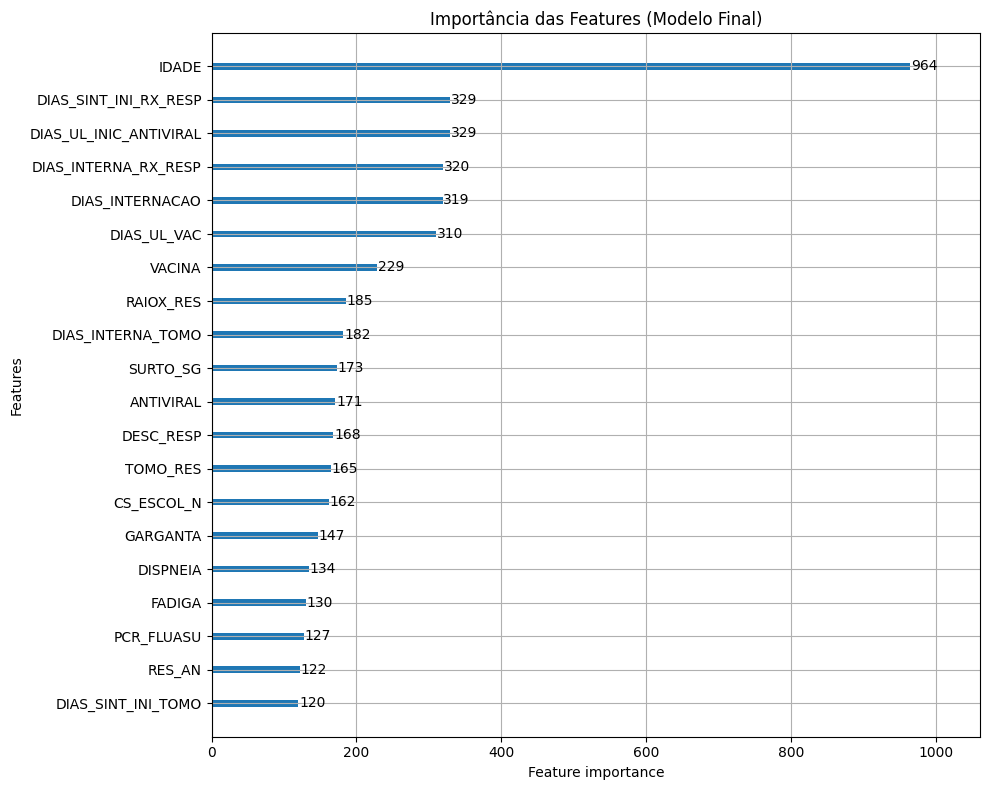

In [39]:
# 2. Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,      # 25% para teste
    random_state=42,     # Para reprodutibilidade
    stratify=y           # Importante para alvos desbalanceados
)

print(f"\nDados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")


# ---
# Bloco 4: Definição da Função 'Objective' para o Optuna
# ---
# Esta função será chamada pelo Optuna em cada tentativa (trial)

def objective(trial):
    # 1. Definimos o espaço de busca dos hiperparâmetros
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'random_state': 42,
        'verbose': -1,  # Desliga os logs do LightGBM
        
        # --- Parâmetros que o Optuna irá "adivinhar" ---
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # % de linhas por árvore
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0) # % de colunas por árvore
        # ------------------------------------------------
    }
    
    # 2. Dividimos o set de TREINO em treino e validação interna
    # Isso é essencial para usar o Early Stopping e Pruning
    X_train_val, X_val, y_train_val, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # 3. Treinamos o modelo com os parâmetros da tentativa (trial)
    model = lgb.LGBMClassifier(**params)
    
    model.fit(
        X_train_val, y_train_val,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            # Pruning: "Poda" tentativas ruins antes de terminarem
            optuna.integration.LightGBMPruningCallback(trial, 'auc')
        ]
    )
    
    # 4. Retornamos a métrica que queremos maximizar
    # Usamos o melhor score de AUC obtido no set de validação
    return model.best_score_['valid_0']['auc']


# ---
# Bloco 5: Execução do Estudo de Otimização
# ---
print("\nIniciando busca de hiperparâmetros com Optuna...")

# 1. Criar o "estudo", definindo a direção (queremos maximizar a AUC)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

# 2. Rodar a otimização
# n_trials é o número de tentativas. 50-100 é um bom começo.
study.optimize(objective, n_trials=50, show_progress_bar=True)

# 3. Mostrar os resultados
print("\nBusca finalizada!")
print(f"Melhor valor de AUC (na validação interna): {study.best_value:.4f}")
print("Melhores hiperparâmetros encontrados:")
print(study.best_params)


# ---
# Bloco 6: Treinamento do Modelo FINAL com Melhores Hiperparâmetros
# ---
print("\nTreinando o modelo final com os melhores parâmetros...")

# 1. Pegar os melhores parâmetros encontrados
best_params = study.best_params

# 2. Instanciar o modelo final com eles
# Garantimos que 'objective', 'metric' etc. estejam presentes
final_params = {
    'objective': 'binary',
    'metric': 'auc',
    'n_jobs': -1,
    'random_state': 42,
    **best_params  # Adiciona os parâmetros ótimos do Optuna
}

final_lgb_model = lgb.LGBMClassifier(**final_params)

# 3. Treinar o modelo final no conjunto de TREINO COMPLETO
# Usamos o conjunto de TESTE como eval_set para monitorar
final_lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)


# ---
# Bloco 7: Avaliação do Modelo Final
# ---
print("\nIniciando avaliação do modelo FINAL no conjunto de Teste...")

y_pred_proba = final_lgb_model.predict_proba(X_test)[:, 1]
y_pred_class = final_lgb_model.predict(X_test)

auc_score = roc_auc_score(y_test, y_pred_proba)
acc_score = accuracy_score(y_test, y_pred_class)

print(f"\n--- Resultados da Avaliação FINAL ---")
print(f"AUC-ROC no Teste: {auc_score:.4f}")
print(f"Acurácia no Teste: {acc_score:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_class))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_class))


# ---
# Bloco 8: Importância das Features (Bônus)
# ---
print("\nGerando gráfico de importância das features...")
try:
    lgb.plot_importance(final_lgb_model, max_num_features=20, figsize=(10, 8))
    plt.title("Importância das Features (Modelo Final)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Não foi possível gerar gráfico: {e}")

## Salva modelo

In [53]:
import joblib

# Assumindo que seu modelo treinado se chama 'final_lgb_model'
caminho_arquivo = 'modelo_lgbm.joblib'

print(f"Salvando modelo em {caminho_arquivo}...")
joblib.dump(final_lgb_model, caminho_arquivo)

print("Modelo salvo com sucesso!")

Salvando modelo em modelo_lgbm.joblib...
Modelo salvo com sucesso!


## Ler modelo

In [ ]:
import joblib
import pandas as pd

# 1. Carregar o modelo
print("Carregando modelo...")
modelo_carregado = joblib.load('modelo_lgbm.joblib')

# 2. Preparar novos dados (EXATAMENTE COMO FEZ NO TREINO)
# (Veja a seção "Importante" abaixo)
novos_dados_raw = pd.DataFrame({
    'quant_1_idade': [30],
    'quant_2_valor_compra': [150.0],
    'quant_3_score_risco': [0.75],
    'cat_1_estado': ['SP'],
    'cat_2_produto': ['Produto C'],
    'cat_3_tipo_cliente': ['Novo'],
    'cat_4_canal_venda': ['Online'],
    'cat_5_codigo_regiao': ['Reg_10']
})

colunas_categoricas = [
    'cat_1_estado', 'cat_2_produto', 'cat_3_tipo_cliente', 
    'cat_4_canal_venda', 'cat_5_codigo_regiao'
]

for col in colunas_categoricas:
    # A transformação DEVE ser idêntica
    novos_dados_raw[col] = novos_dados_raw[col].astype('category')


# 3. Fazer predições
print("Fazendo predições...")
# A API do scikit-learn é mantida
probabilidades = modelo_carregado.predict_proba(novos_dados_raw)
classe_predita = modelo_carregado.predict(novos_dados_raw)

print(f"Probabilidade (Classe 0, Classe 1): {probabilidades}")
print(f"Classe Predita: {classe_predita}")

## Cria docker para deploy

In [ ]:
# app.py
import os
import joblib
import pandas as pd
from flask import Flask, request, jsonify

# 1. Inicializar o App Flask
app = Flask(__name__)

# 2. Carregar o pipeline (apenas uma vez, quando o app inicia)
model_path = "modelo_lgbm.joblib"
try:
    pipeline = joblib.load(model_path)
    print("Modelo carregado com sucesso.")
except Exception as e:
    print(f"Erro ao carregar o pipeline: {e}")
    pipeline = None

# 3. Definir um endpoint de "health check"
@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({"status": "healthy"}), 200

# 4. Definir o endpoint de predição
@app.route('/predict', methods=['POST'])
def predict():
    if pipeline is None:
        return jsonify({"error": "Modelo não carregado"}), 500

    try:
        # 1. Pegar os dados JSON da requisição
        data = request.get_json(force=True)
        
        # 2. Converter o JSON para um DataFrame do Pandas
        # Esperamos um JSON no formato de 'colunas' ou 'dicionário de linhas'
        # Ex: { "col_a": [1, 2], "col_b": ["x", "y"] }
        # ou: [ { "col_a": 1, "col_b": "x" }, { "col_a": 2, "col_b": "y" } ]
        
        # Este formato é mais flexível:
        if isinstance(data, list):
            predict_df = pd.DataFrame.from_records(data)
        elif isinstance(data, dict):
             # Se for um único registro: { "col_a": 1, "col_b": "x" }
             # ou múltiplos registros: { "col_a": [1, 2], "col_b": ["x", "y"] }
            predict_df = pd.DataFrame(data)
        else:
            return jsonify({"error": "Formato JSON não suportado"}), 400

        # 3. Usar o pipeline para pré-processar E prever
        # O pipeline lida com dados "crus"
        probabilidades = pipeline.predict_proba(predict_df)
        
        # 4. Formatar a resposta
        # Vamos retornar a probabilidade da classe '1' (positiva)
        output = list(probabilidades[:, 1])
        
        return jsonify({"predictions_prob_class_1": output})

    except Exception as e:
        return jsonify({"error": str(e)}), 400

# 5. Rodar o app (apenas para debug local, NÃO para produção)
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)

In [ ]:
pd.crosstab(dados['UTI'], dados['VACINA'], margins=True, margins_name='Total', normalize='columns')

In [23]:
pd.crosstab(dados['UTI'], dados['SURTO_SG'], margins=True, margins_name='Total', normalize='columns')

SURTO_SG,1.0,2.0,9.0,Total
UTI,,,,
1.0,0.269262,0.291469,0.371022,0.295286
2.0,0.730738,0.708531,0.628978,0.704714


In [51]:
dados.loc[dados['UTI']==1, 'IDADE'].mean()/365.25

np.float64(42.89636237326957)

In [49]:
dados.loc[dados['UTI']==1, 'IDADE'].std()

np.float64(11729.658616801431)

In [52]:
dados.loc[dados['UTI']==2, 'IDADE'].mean()/365.25

np.float64(37.294209289565)

In [50]:
dados.loc[dados['UTI']==2, 'IDADE'].std()

np.float64(12213.656139173283)